# Coverage statistics / plots of selected sequences

In [1]:
%run "Header.ipynb"
%run "LoadMutationJSONData.ipynb"

### Real quick: what are the average coverages of each sequence?

In [2]:
for seq in SEQS:
    covs = seq2pos2totalcov[seq].values()
    mean_cov = mean(covs)
    median_cov = median(covs)
    print("Sequence {} has average coverage {} and median coverage {}.".format(seq, mean_cov, median_cov))

Sequence edge_6104 has average coverage 4255.718018466636 and median coverage 4172.0.
Sequence edge_1671 has average coverage 1444.405394461023 and median coverage 1460.0.
Sequence edge_2358 has average coverage 3009.58110742755 and median coverage 2947.


### Plot coverages across genomes

In [3]:
def show_coverage_plot(seq, axes, binlen=None, verbose=False):
    """seq should be an entry in SEQS. binlen can be None (if every position should be plotted),
    or it can be an integer -- in which case this will bin this many positions and just plot
    the average coverage within each bin (bins are not guaranteed to correspond to a uniform number
    of positions in the sequence unless the length of the sequence is exactly divisible by binlen).
    """
    # seq2pos2cov stores positions as strings, but we need to plot them as ints
    int_positions = sorted([int(p) for p in seq2pos2totalcov[seq].keys()])
    
    # quick sanity check: int_positions should not have any gaps
    assert int_positions == list(range(1, len(int_positions) + 1))
    
    str_positions = [str(p) for p in int_positions]
    coverages = [seq2pos2totalcov[seq][pos] for pos in str_positions]
    
    title = "{}: Coverage across genome (length {:,} bp)".format(seq2name[seq], len(int_positions))
    
    if binlen is None:
        axes.scatter(int_positions, coverages, c=SCATTERPLOT_PT_COLOR)
    else:
        seqlen = len(int_positions)
        if verbose: print("Doing binning. Seq len for {} is {}".format(seq, seqlen))
        if binlen < 1 or binlen > seqlen:
            # A bin length of 1 shouldn't change anything, compared with binlen=None (since at that
            # point each bin maps one-to-one to a position); a bin length equal to the sequence length
            # just transforms this into plotting a single point with the average coverage across the
            # whole sequence. Anything below or above either of these makes no sense.
            raise ValueError("binlen is outside of [1, seq length].")
        binned_positions = []
        binned_coverages = []
        left_pos = 1
        while left_pos + binlen - 1 <= seqlen:
            # The -1 is needed to fit things in properly.
            # For example, say our sequence is ABCDEFGHIJKLMNOP (start = 1, end = 16).
            # Bins w/ length 3:                1234567890123456
            #                                  ---===---===---=
            # The [left pos, right pos] intervals are:
            # [1, 3], [4, 6], [7, 9], [10, 12], [13, 15], [16]
            right_pos = left_pos + binlen - 1
            binned_positions.append((left_pos + right_pos) / 2)
            positions = range(left_pos, right_pos + 1)
            mean_cov = mean([coverages[p - 1] for p in positions])
            if mean_cov > 8000:
                print("Bin with average coverage > 8 kbp in {} from [{}, {}]".format(
                    seq2name[seq], left_pos, right_pos
                ))
                if mean_cov > 40000:
                    print("ALSO THIS SAME BIN HAS AVERAGE COVERAGE > 40 kbp: cov is {:,}".format(mean_cov))
            binned_coverages.append(mean_cov)
            if verbose: print("Created bin for [{}, {}]".format(left_pos, right_pos))
            left_pos = right_pos + 1

        # Unless seqlen was evenly divisible by binlen, there will be some extra positions not
        # in any bins yet (at the right end of the sequence). Create a new bin to hold these.
        if left_pos <= seqlen:
            positions = range(left_pos, seqlen + 1)
            binned_positions.append((positions[0] + positions[-1]) / 2)
            mean_cov = mean([coverages[p - 1] for p in positions])
            binned_coverages.append(mean_cov)
            if verbose: print("Created extra bin for [{}, {}]".format(positions[0], positions[-1]))
            title += "\nEvery dot but the rightmost represents a bin of {:,} bp.".format(binlen)
            title += " The rightmost dot is a bin of {:,} bp.".format(len(positions))
        else:
            title += "\nEvery dot represents a bin of {:,} bp.".format(binlen)

        axes.scatter(binned_positions, binned_coverages, c=SCATTERPLOT_PT_COLOR)
        
    axes.set_title(title)
    axes.set_xlabel("Sequence position")
    if binlen is None:
        axes.set_ylabel("Coverage")
    else:
        axes.set_ylabel("Average coverage within each bin")
    
    # Limit the number of ticks on the x-axis, to avoid overlapping position labels.
    # https://stackoverflow.com/a/13418954
    axes.locator_params(axis="x", nbins=10)
    
    use_thousands_sep(axes.get_xaxis())
    use_thousands_sep(axes.get_yaxis())
    
    axes.set_ylim(0)

#### Coverages: no binning, one dot per position

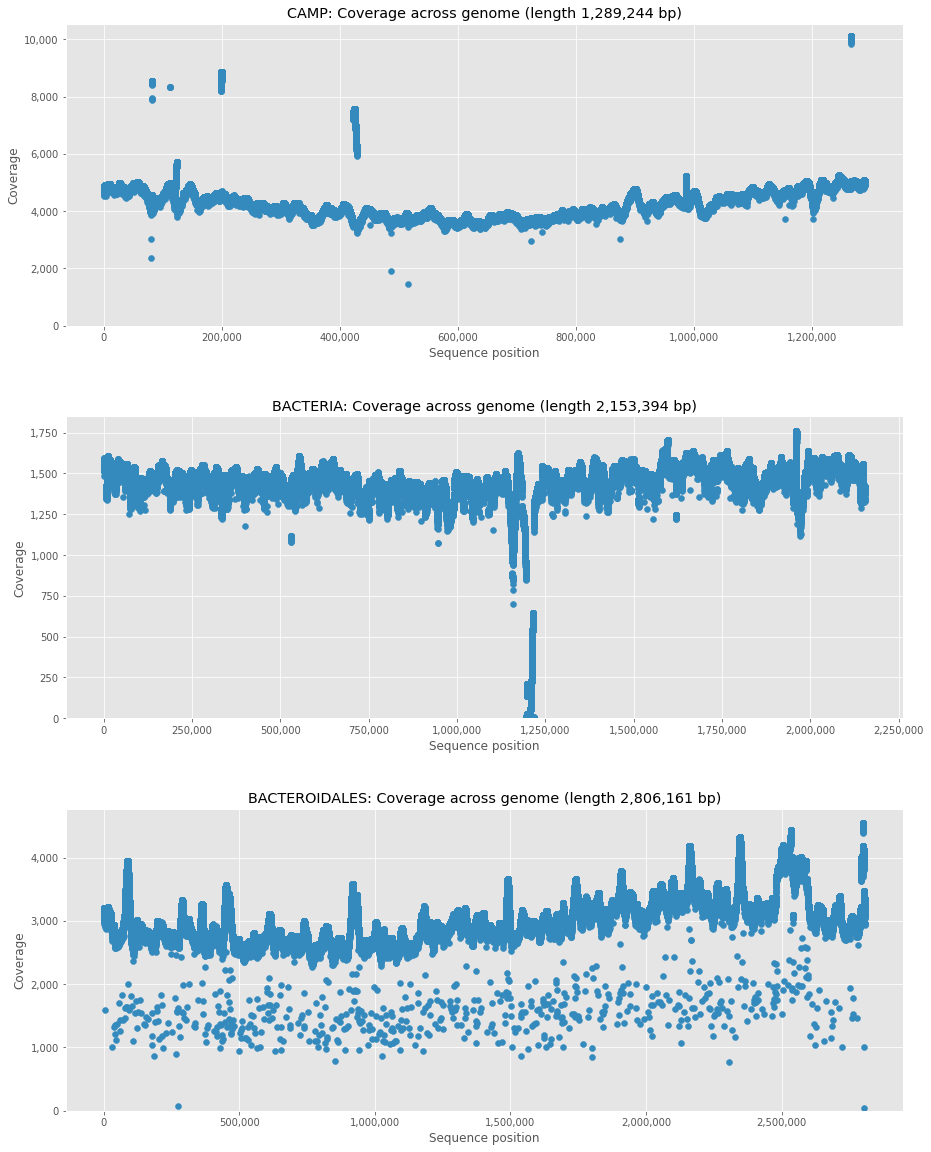

In [4]:
figN, (ax1N, ax2N, ax3N) = pyplot.subplots(3, gridspec_kw={"hspace": 0.3})
show_coverage_plot("edge_6104", ax1N)
show_coverage_plot("edge_1671", ax2N)
show_coverage_plot("edge_2358", ax3N)
figN.set_size_inches(15, 20)
# Remove gratuitous whitespace in saved image: https://stackoverflow.com/a/11847260
figN.savefig("figs/seq-coverage-unbinned.png", bbox_inches="tight")

#### Coverages: with binning every 1 kbp
Subplot stuff based on [the matplotlib docs](https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html) and [this Stack Overflow comment](https://stackoverflow.com/a/35881382) (from which I learned about `gridspec_kw`).

Bin with average coverage > 8 kbp in CAMP from [199001, 200000]


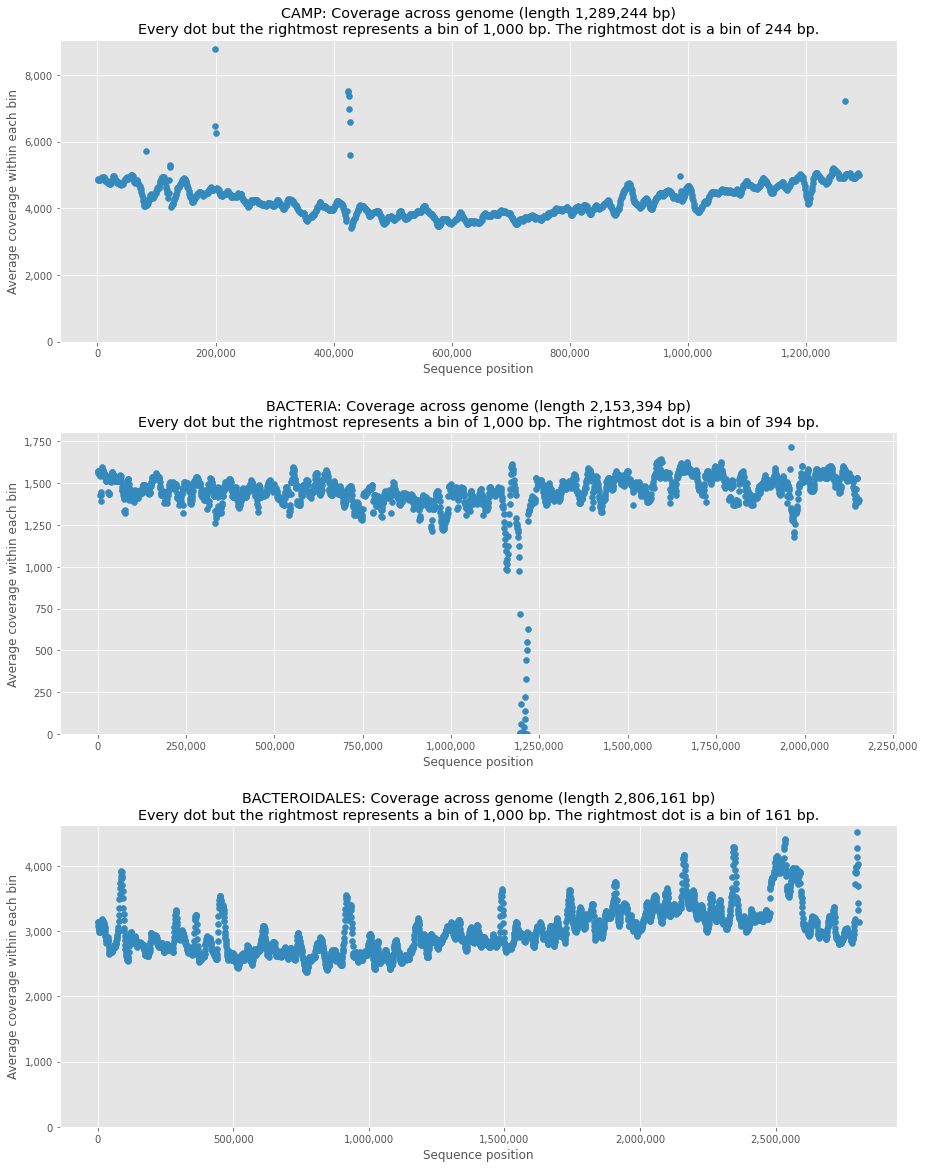

In [5]:
fig, (ax1, ax2, ax3) = pyplot.subplots(3, gridspec_kw={"hspace": 0.3})
show_coverage_plot("edge_6104", ax1, binlen=1000)
show_coverage_plot("edge_1671", ax2, binlen=1000)
show_coverage_plot("edge_2358", ax3, binlen=1000)
fig.set_size_inches(15, 20)
# Remove gratuitous whitespace in saved image: https://stackoverflow.com/a/11847260
fig.savefig("figs/seq-coverage-binned.png", bbox_inches="tight")

In [6]:
int_positions = sorted([int(p) for p in seq2pos2totalcov["edge_2358"].keys()])

# quick sanity check: int_positions should not have any gaps
assert int_positions == list(range(1, len(int_positions) + 1))

str_positions = [str(p) for p in int_positions]
covs = [seq2pos2totalcov["edge_2358"][pos] for pos in str_positions]

In [7]:
outlier_positions = []
outlier_covs = []
for i, c in enumerate(covs, 1):
    if c < 2000:
        outlier_positions.append(i)
        outlier_covs.append(c)
print("{} positions with cov < 2,000x".format(len(outlier_positions)))
print("Average cov of these positions: {:.2f}x".format(mean(outlier_covs)))

515 positions with cov < 2,000x
Average cov of these positions: 1482.81x


In [8]:
print(outlier_positions)

[2901, 31866, 37880, 39860, 43075, 45333, 47225, 57740, 59933, 61135, 68388, 72078, 76635, 79230, 80344, 85424, 91577, 94075, 99131, 105831, 107408, 116994, 119165, 123313, 124671, 132407, 138096, 149058, 152638, 154604, 164086, 176163, 177462, 178436, 184000, 189023, 196258, 197450, 199313, 203193, 210615, 213166, 214753, 219945, 227802, 238554, 250617, 263952, 265916, 269565, 271196, 274430, 275417, 277900, 280170, 287036, 290735, 292085, 297258, 305132, 308409, 334141, 335689, 337087, 345893, 365452, 367084, 374862, 376414, 380466, 384941, 405564, 409754, 415324, 416414, 417311, 419692, 423522, 428675, 428676, 430361, 433932, 434614, 436410, 438468, 444677, 445367, 454166, 455949, 462571, 463591, 464581, 468207, 469791, 470825, 473719, 477770, 480896, 499330, 502984, 505992, 507027, 509177, 511000, 522187, 525633, 532046, 533336, 536219, 538803, 541254, 543876, 552020, 553172, 556825, 564431, 566805, 571904, 574665, 580188, 588540, 589427, 600387, 601550, 604080, 605956, 607915, 611